# Generating modified dataset for new training

In [1]:
import os, json
import pandas as pd
import tqdm
import numpy as np
from PIL import Image
import torch
import random
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter

/home/matteopierucci/anaconda3/envs/clipcount/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "./data_mod_mosaic/FSC/FSC_147"
split_images_file = "Train_Test_Val_FSC_147.json"
dot_annotations_file = "annotation_FSC147_384.json"
split_classes_file = "Split_Classes_FSC147.json"
descriptions_file = "./FSC-147-D.json"

img_class_txt = "ImageClasses_FSC147.txt"

with open(os.path.join(data_dir, split_images_file), 'r') as f:
    split_images = json.load(f)    
    
with open(os.path.join(data_dir, dot_annotations_file), 'r') as f:
    dot_annotations = json.load(f)
    
with open( descriptions_file, 'r') as f:
    descriptions = json.load(f)
    
with open(os.path.join(data_dir, split_classes_file), 'r') as f:
    split_classes = json.load(f)
    
img_classes = {}

with open(os.path.join(data_dir, img_class_txt), 'r') as file:
    for line in file:
        line = line.strip().split('\t')
        if len(line) == 2:
            img_name, label = line
            img_classes[img_name] = label

In [3]:
def create_collage(image1, image2, type, first):
    # resize images to be same size
    if first:
        width, height = image1.size[0], image1.size[1]
    else:
        width, height = image2.size[0], image2.size[1]

    if type == "vertical":
        
        #width = height
        height = height//2
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        # new collage image with double width
        collage = Image.new('RGB', (width, height * 2))

        # paste images onto the collage
        collage.paste(image1, (0, 0))
        collage.paste(image2, (0, height))
    
    elif type == "horizontal":
        
        image1 = image1.resize((width, height))
        image2 = image2.resize((width, height))
        # new collage image with double width
        collage = Image.new('RGB', (width * 2, height))

        # paste images onto the collage
        collage.paste(image1, (0, 0))
        collage.paste(image2, (width, 0))

    cv2_collage = np.array(collage)
    cv2_collage = cv2.cvtColor(cv2_collage, cv2.COLOR_RGB2BGR)
    return cv2_collage, collage

In [4]:
train_list = split_images['train']
val_list = split_images['val']
train_val_images = train_list + val_list

In [5]:
img_directory = './data_mod_mosaic/FSC/images_384_VarV2'
density_directory = './data_mod_mosaic/FSC/gt_density_map_adaptive_384_VarV2'

In [6]:
random.seed(123)
new_im_id = 7715
class_tuples = []

for img_filename in tqdm.tqdm(train_val_images):
    
    img = Image.open(os.path.join(img_directory, img_filename))
    img.load()
    
    new_filename = f"{new_im_id}.jpg"
    #print(img.size)
    
    img2_class = img_classes[img_filename]
    # load another image in the same set
    if img_filename in train_list:
        while img2_class == img_classes[img_filename]:
            #print("same class: ", img2_class, "-", img_classes[img_filename])
            img2_filename = split_images['train'][random.randint(0, len(split_images['train']) - 1)]
            img2_class = img_classes[img2_filename]
    elif img_filename in val_list:
        while img2_class == img_classes[img_filename]:
            #print("same class: ", img2_class, "-", img_classes[img_filename])
            img2_filename = split_images['val'][random.randint(0, len(split_images['val']) - 1)]
            img2_class = img_classes[img2_filename]
    
    class_tuples.append((img_classes[img_filename], img2_class))
    
    img2 = Image.open(os.path.join(img_directory, img2_filename))
    
    # create collage with retrieved image
    if new_im_id % 2 == 0:
        _, collage = create_collage(img, img2, "vertical", True)
    else:
        _, collage = create_collage(img2, img, "vertical", False)
        
    collage.save(os.path.join(img_directory, new_filename))
    #print(collage.size)
    
    # load density map of img 1, which can be the top or bottom image of the collage
    loaded_density_map = np.load(os.path.join(density_directory, img_filename.split('.')[0] + '.npy' ))
    loaded_density_map = loaded_density_map * 2
    empty_density_shape = loaded_density_map.shape
    empty_density_map = np.zeros(empty_density_shape, dtype=np.float32)
    #print(loaded_density_map.shape)
    

    # stack the arrays along a new axis (e.g., along the first axis)
    if new_im_id % 2 == 0:
       stacked_density_map = np.concatenate((loaded_density_map, empty_density_map), axis=0)
    else:
        stacked_density_map = np.concatenate((empty_density_map, loaded_density_map), axis=0)
    
    density_height = stacked_density_map.shape[0]
    density_width = stacked_density_map.shape[1]
    
    stacked_density_map = stacked_density_map.reshape(density_height//2, 2, density_width).mean(axis=1)
    stacked_density_filename = f"{new_im_id}.npy"
    np.save(os.path.join(density_directory, stacked_density_filename), stacked_density_map)

    # updated of split_images
    if img_filename in train_list:
        split_images['train'].extend([new_filename])
    elif img_filename in val_list:
        split_images['val'].extend([new_filename])
    
    # update of img_classes
    cur_img_class = img_classes[img_filename]
    img_classes[new_filename] = cur_img_class
    
    
    new_image_descr = {
        "data_split": "train" if img_filename in train_list else "val",
        "text_description": descriptions[img_filename]['text_description']
    }
    
    descriptions[new_filename] = new_image_descr
    
    H = dot_annotations[img_filename]["H"]
    W = dot_annotations[img_filename]["W"]
    #box_examples_coordinates = dot_annotations[img_filename]["box_examples_coordinates"]
    #box_examples_path = dot_annotations[img_filename]["box_examples_path"]
    #density_path = dot_annotations[img_filename]["density_path"]
    #density_path_fixed = dot_annotations[img_filename]["density_path_fixed"]
    #img_path = dot_annotations[img_filename]["img_path"]
    #points = dot_annotations[img_filename]["points"]
    r = dot_annotations[img_filename]["r"]
    ratio_h = dot_annotations[img_filename]["ratio_h"]
    ratio_w = dot_annotations[img_filename]["ratio_w"]
    
    # change points based on the mosaic transformation
    #print(stacked_density_map.shape)
    np_points = peak_local_max(stacked_density_map, min_distance=1)
    
    points = []
    for point in np_points:
        y, x = point
        points.append([int(x), int(y)])
        
    new_image_annotation = {
        "H": collage.size[1],
        "W": collage.size[0],
        "box_examples_coordinates": [],
        "box_examples_path": '',
        "density_path": '',
        "density_path_fixed": '',
        "img_path": '',
        "points": points,
        "r": '',
        "ratio_h": '',
        "ratio_w": ''
    }
    
    dot_annotations[new_filename] = new_image_annotation
    
    new_im_id += 1
    #print("------")

  0%|          | 9/4945 [00:00<03:58, 20.73it/s]

100%|██████████| 4945/4945 [04:21<00:00, 18.95it/s]


In [7]:
split_images_mod_file = "Train_Test_Val_FSC_147_mod_mosaic.json"
img_class_mod_txt = "ImageClasses_FSC147_mod_mosaic.txt"
descriptions_mod_file = "./FSC-147-D_mod_mosaic.json"
dot_annotations_mod_file = "annotation_FSC147_384_mod_mosaic.json"

with open(os.path.join(data_dir, split_images_mod_file), 'w') as file:
    json.dump(split_images, file, indent=4)
    
with open(os.path.join(data_dir, img_class_mod_txt), 'w') as file:
    for key, value in img_classes.items():
        file.write(f"{key}\t{value}\n")
        
with open(descriptions_mod_file, 'w') as file:
    json.dump(descriptions, file, indent=4)
    
with open(os.path.join(data_dir, dot_annotations_mod_file), 'w') as file:
    json.dump(dot_annotations, file, indent=4)

In [8]:
class_tuples

[('peppers', 'crows'),
 ('bread rolls', 'cups'),
 ('bread rolls', 'oranges'),
 ('bread rolls', 'cupcake tray'),
 ('bread rolls', 'pens'),
 ('bread rolls', 'cars'),
 ('bread rolls', 'cassettes'),
 ('bread rolls', 'pigeons'),
 ('bread rolls', 'beads'),
 ('bread rolls', 'beads'),
 ('bread rolls', 'biscuits'),
 ('bread rolls', 'cupcakes'),
 ('tomatoes', 'stairs'),
 ('tomatoes', 'coins'),
 ('tomatoes', 'crows'),
 ('tomatoes', 'alcohol bottles'),
 ('tomatoes', 'cups'),
 ('tomatoes', 'stairs'),
 ('tomatoes', 'cotton balls'),
 ('tomatoes', 'cupcakes'),
 ('tomatoes', 'beads'),
 ('tomatoes', 'candles'),
 ('tomatoes', 'alcohol bottles'),
 ('tomatoes', 'bread rolls'),
 ('tomatoes', 'cranes'),
 ('tomatoes', 'cereals'),
 ('tomatoes', 'fishes'),
 ('tomatoes', 'alcohol bottles'),
 ('tomatoes', 'beads'),
 ('tomatoes', 'beads'),
 ('tomatoes', 'cranes'),
 ('tomatoes', 'candles'),
 ('tomatoes', 'beads'),
 ('tomatoes', 'cows'),
 ('tomatoes', 'crows'),
 ('tomatoes', 'plates'),
 ('tomatoes', 'coins'),
 ('tom

### Check on created density maps

In [37]:
test_img_filename = '11116'

In [38]:
loaded_density_map = np.load(os.path.join(density_directory, test_img_filename + '.npy' ))

In [39]:
tensor = torch.Tensor(loaded_density_map)
torch.sum(tensor).item()

39.999996185302734

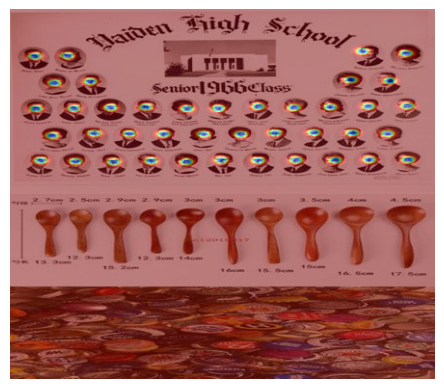

In [40]:
image = cv2.imread(os.path.join(img_directory, test_img_filename + '.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

density_map_resized = cv2.resize(loaded_density_map, (image.shape[1], image.shape[0]))

# Normalize the density map to the range [0, 255] and convert to uint8
density_map_normalized = cv2.normalize(density_map_resized, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Convert the single-channel density map to a three-channel image by duplicating the grayscale values across RGB channels
density_map_colored = cv2.applyColorMap(density_map_normalized, cv2.COLORMAP_JET)

# Set the alpha for blending
alpha = 0.5

# Blend the image and the colored density map
superimposed_image = cv2.addWeighted(image, 1 - alpha, density_map_colored, alpha, 0)

# Display the image
plt.imshow(superimposed_image)
plt.axis('off')  # Hide axes
plt.show()

In [43]:
dot_annotations_mod_file = "annotation_FSC147_384_mod_mosaic.json"
with open(os.path.join(data_dir, dot_annotations_mod_file), 'r') as f:
    dot_annotations = json.load(f)

In [44]:
points = dot_annotations[test_img_filename + '.jpg']["points"]
len(points)

40

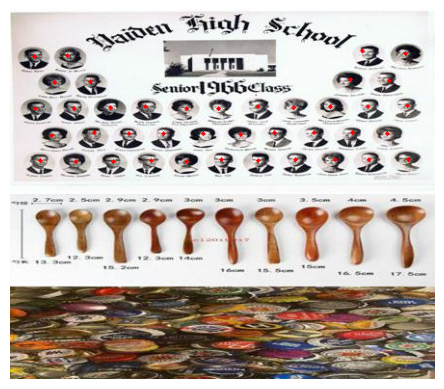

In [45]:
image = cv2.imread(os.path.join(img_directory, test_img_filename + '.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

for point in points:
    # Unpack the x, y coordinates
    x, y = point
    # Draw the point on the image
    cv2.circle(image, (int(x), int(y)), radius=2, color=(255, 0, 0), thickness=-1)  # Red color in BGR

plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()